# Downsampling
## Idea:
* Two dataset variants have different sizes, need same size to compare other dataset properties
* -> sample down the larger one, i.e. draw a random sample
## Question:
* Does the downsampling method affect attribute value frequencies?

In [1]:
from dataset_properties import split_by_source_id
from dataset_modifier import random_sample, random_sample_wrapper
import numpy as np
import scipy.stats as stats

In [2]:
import pandas as pd
# get the data
filepath = "data/2021_NCVR_Panse_001/dataset_ncvr_dirty.csv"
col_names = "sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE".split(",")
df = pd.read_csv(filepath, names=col_names, dtype={"PLZ": str, "YEAROFBIRTH": int},
                              keep_default_na=False)
df.head()

,sourceID,globalID,localID,FIRSTNAME,MIDDLENAME,LASTNAME,YEAROFBIRTH,PLACEOFBIRTH,COUNTRY,CITY,PLZ,STREET,GENDER,ETHNIC,RACE
0,A,AM28693,1fdc308dcc35344c6d5c20845fad641d,SUE,BARNES,SHUFFLER,1946,,BURKE,VALDESE,28690,LAKEVIEW ACRES,F,NL,W
1,A,CZ67291,b36b8c16c743ed415c6a7f3fc1a3b859,RONALD,EUGENE,LATTIMER,1953,OH,MOORE,PINEHURST,28374,BURNING TREE,M,NL,W
2,A,BN204837,401b7f6f5e107dbb009da197a2b05d9e,DEIDRE,MARLANA,MARTIN,1973,NC,FORSYTH,WINSTON SALEM,27105,CARVER GLEN,F,NL,B
3,A,EH737737,85f059d91b803b5835a8b9762a3170cb,KURT,,BALEN,1968,PA,WAKE,APEX,27502,ASHLEY DOWNS,M,NL,W
4,A,DT41462,f70a42ce915731cabafc5daa1bfbceeb,WORTH,BROWN,FOUTZ,1919,,ROWAN,SALISBURY,28146,MORRISON,M,NL,W


### Idea:
* Describe attr. value frequency-distribution by its skewness
#### Skewness of FIRSTNAME

In [3]:
df.FIRSTNAME.value_counts().skew()

22.40701130969864

In [4]:
df_a, df_b = split_by_source_id(df)
df_res = random_sample(df_a, df_b, 100_000)
df_res.FIRSTNAME.value_counts().skew()

17.600463921421596

In [5]:
df_res = random_sample(df_a, df_b, 50_000)
df_res.FIRSTNAME.value_counts().skew()

14.069596605982268

In [6]:
df_res = random_sample(df_a, df_b, 10_000)
df_res.FIRSTNAME.value_counts().skew()

8.870749282770134

### Skewness influenced by sample size

In [7]:
# same with regular random sample:
df.sample(50_000).FIRSTNAME.value_counts().skew()

14.188531169285039

#### Plot it

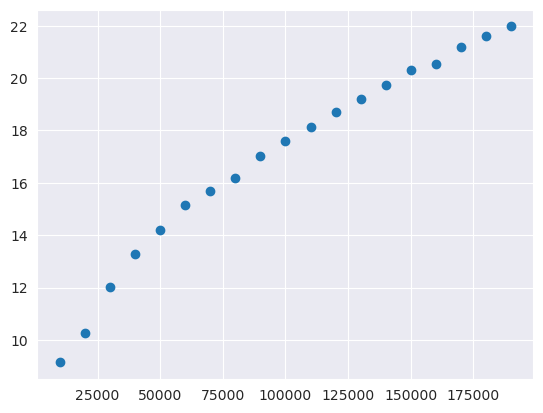

In [8]:
import matplotlib.pyplot as plt

sizes = list(range(10_000, 200_000, 10_000))  # [10k, 20k, ..., 190k]
plt.scatter(
    x=sizes,
    y=[random_sample(df_a, df_b, s).FIRSTNAME.value_counts().skew() for s in sizes]
)

### Compare two frequency distributions
https://stats.stackexchange.com/questions/289021/statistical-test-for-comparing-two-frequency-distributions-expressed-as-arrays

### Observation:
* Skewness influenced by random down-sampling
### Question: TODO
* Should skew be preserved when sampling down?
* If so, how to?

### Approach 1 (under the incorrect assumption that skewness is amplified by dataset size. Actually, it is influenced by random down-sampling)
Method Parameters:
* df1, df2 -> the two datasets whose skewnesses should be compared, i.e. the original dataset and the down-sampled version.
* sample_size -> the size of the random samples that should be drawn per iteration

In [ ]:
from scipy.stats import ttest_ind

def compare_skews(df1, df2, attr_name, sample_size, iterations):
    skews1 = []
    skews2 = []
    for i in range(iterations):
        # to compare skewness, need same sized random subsets (skew is amplified by dataset size)
        skew1, skew2 = [df[attr_name].sample(sample_size,
                                             random_state=i).value_counts().skew()
                        for df in (df1, df2)]
        skews1.append(skew1)
        skews2.append(skew2)
    return ttest_ind(skews1, skews2).pvalue

In [ ]:
# split dataset into two sources a and b
df_a, df_b = split_by_source_id(df)

In [ ]:
downsampling_size = 50_000
sample_size = 10_000
iterations = 1000
seed = 42
df_res = random_sample(df_a, df_b, downsampling_size, seed)
compare_skews(df, df_res, "FIRSTNAME", sample_size, iterations)

In [ ]:
seed = 43
df_res = random_sample(df_a, df_b, downsampling_size, seed)
compare_skews(df, df_res, "FIRSTNAME", sample_size, iterations)

### Nur durch Veränderung des Seeds komplett anderes Ergebnis
* Erwartung war eigentlich, mit den vielen Iterationen den Zufallsfaktor auszugleichen
* D.h. vllt stimmt etwas mit der compare_skews Methode nicht.
* Vielleicht ist aber auch die Sample Größe (50k) einfach zu klein, sodass schon mal durch Zufall eine etwas andere Attributwert-Verteilung heraus kommen kann? Dann bräuchte ich zum Testen einen größeren Datensatz (ca 1M)

In [ ]:
# a closer look at the skew lists
df1 = df
df2 = df_res
skews1 = []
skews2 = []
for i in range(iterations):
    # to compare skewness, need same sized random subsets (skew is amplified by dataset size)
    skew1, skew2 = [df.FIRSTNAME.sample(sample_size,
                                         random_state=i).value_counts().skew()
                    for df in (df1, df2)]
    skews1.append(skew1)
    skews2.append(skew2)

In [ ]:
from scipy.stats import describe

In [ ]:
describe(skews1)

In [ ]:
describe(skews2)

In [ ]:
import seaborn as sns

In [ ]:
sns.boxplot(data=[skews1, skews2])
plt.show()

In [ ]:
from tqdm import tqdm

def compare_skews2(df, downsampling_size, attr_name, sample_size, iterations, seed_incr=0):
    df_a, df_b = split_by_source_id(df)
    skews1 = []
    skews2 = []
    for i in tqdm(range(iterations)):
        df_res = random_sample(df_a, df_b, downsampling_size, seed=i+seed_incr)
        skew1, skew2 = [
            _df.sample(sample_size, random_state=i)[attr_name].value_counts().skew()
            for _df in (df, df_res)
        ]
        skews1.append(skew1)
        skews2.append(skew2)
    return (skews1, skews2)

In [ ]:
downsampling_size = 5000
sample_size = 1000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

In [ ]:
downsampling_size = 5000
sample_size = 1000
iterations = 100
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

In [ ]:
downsampling_size = 10_000
sample_size = 1000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

In [ ]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations)
ttest_ind(skews1, skews2).pvalue

In [ ]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=1)
ttest_ind(skews1, skews2).pvalue

In [ ]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=2)
ttest_ind(skews1, skews2).pvalue

In [ ]:
downsampling_size = 50_000
sample_size = 5000
iterations = 1000
(skews1, skews2) = compare_skews2(df, downsampling_size, "FIRSTNAME", sample_size, iterations,
                                  seed_incr=3)
ttest_ind(skews1, skews2).pvalue

## New Approach:
Compare the Frequency Distributions of both datasets
* chi² GOF test https://stats.stackexchange.com/questions/289021/statistical-test-for-comparing-two-frequency-distributions-expressed-as-arrays
* KL-Divergence
* Rank Correlation Coefficient
* Anderson-Darling test

#### Chi-Square GOF test
* Requires same number of categories
* Requires same sum of frequencies

In [10]:
from scipy.stats import chisquare

In [11]:
df_res = random_sample_wrapper(df, 50_000, seed=42)

In [12]:
def make_decision(p_value):
    """
    Makes a goodness-of-fit decision on an input p-value.
    Input: p_value: the p-value from a goodness-of-fit test.
    Returns: "different" if the p-value is below 0.05, "same" otherwise
    """
    return "different" if p_value < 0.05 else "same"

In [13]:
e = df.FIRSTNAME.value_counts().sort_values(ascending=False)
o = df_res.FIRSTNAME.value_counts().sort_values(ascending=False)

In [14]:
# filter the categories that are not in both datasets
e = e[e.index.isin(o.index)]
e.shape == o.shape

True

In [15]:
# scale equally
e_scaled = e / float(sum(e)) * sum(o)

In [16]:
p = stats.chisquare(o, e_scaled)[1]
p

0.9628106671760044

In [17]:
make_decision(p)

'same'

In [18]:
import matplotlib.pyplot as plt

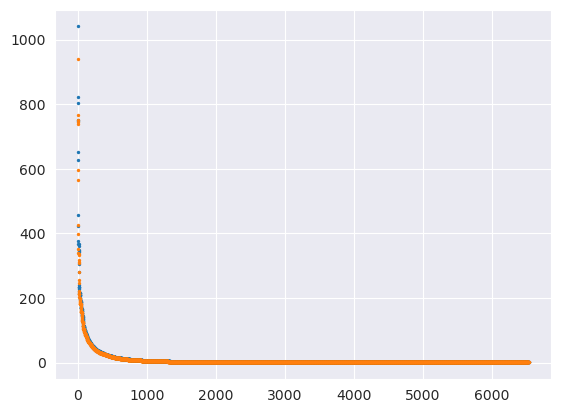

In [19]:
for s in [e_scaled, o]:
    plt.scatter(x=range(s.shape[0]), y=s.tolist(), s=2)

#### Observation:
* Chi test says data is similar
* Data looks the same

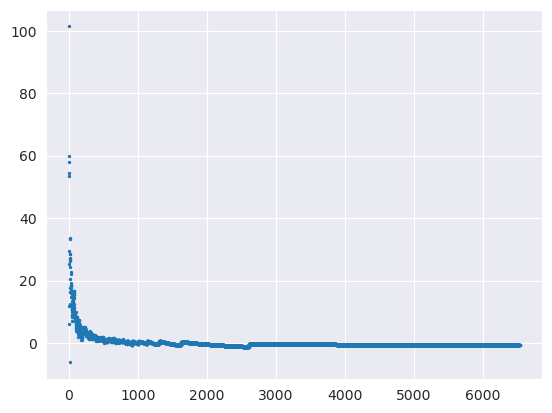

In [20]:
diff = e_scaled.values - o.values
plt.scatter(x=range(diff.shape[0]), y=diff, s=2)

In [21]:
diff

array([101.38241083,  54.57188588,  53.53859797, ...,  -0.72963035,
        -0.72963035,  -0.72963035])

In [22]:
diff.mean()

-6.955450457119366e-17

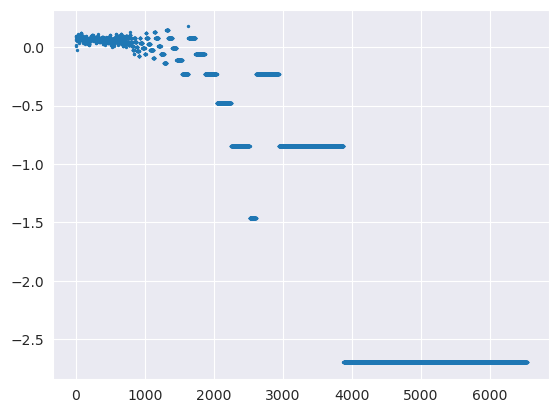

In [23]:
diff_rel = (e_scaled.values - o.values) / e_scaled.values
plt.scatter(x=range(diff_rel.shape[0]), y=diff_rel, s=2)

#### Observation:
* Difference of value-sorted frequencies is higher, the higher the value counts
* Mean difference is almost 0

#### But index positions of categories are different
What happens if index positions are same?

In [24]:
p = chisquare(o.sort_index(), e_scaled.sort_index())[1]
p

1.2168179645753695e-116

In [25]:
make_decision(p)

'different'

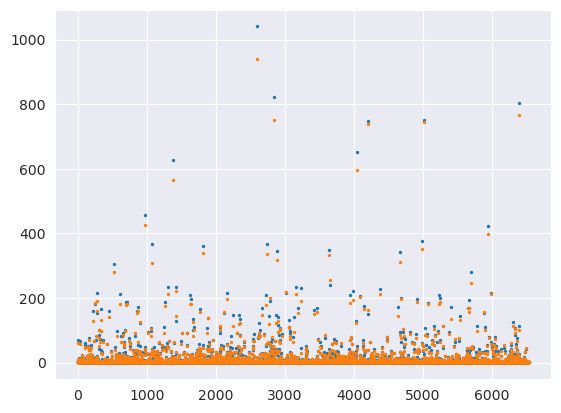

In [26]:
for s in [e_scaled.sort_index(), o.sort_index()]:
    plt.scatter(x=range(s.shape[0]), y=s.tolist(), s=2)

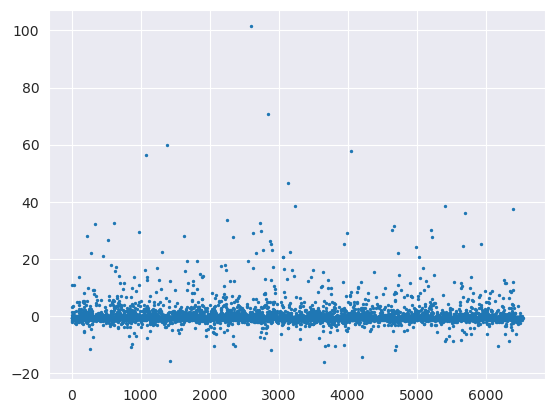

In [27]:
diff = e_scaled.sort_index() - o.sort_index()
plt.scatter(x=range(diff.shape[0]), y=diff.tolist(), s=2)

In [28]:
diff.mean()

0.0

#### Observation:
* Chi Test says data is different
* But plots still looks similar
* Difference is exactly 0

#### Kullback-Leibler divergence
The Kullback-Leibler (KL) divergence is a measure of the difference between two probability distributions. It calculates the amount of information lost when approximating one distribution with another. A lower KL divergence value between two distributions indicates that they are more similar, while a higher value indicates that they are more dissimilar.

from the documentation:
If qk is not None, then compute the relative entropy D = sum(pk * log(pk / qk)). This quantity is also known as the Kullback-Leibler divergence.
This routine will normalize pk and qk if they don’t sum to 1.

In [29]:
from scipy.stats import entropy

In [30]:
D = entropy(e, o, 2)
D

0.04056156190637871

In [31]:
D = entropy(e_scaled, o, 2)
D

0.04056156190637897

#### Observation:
* 0.04 is small, suggests that the distributions are similar
* KLD does not depend on scaling

But here, again, order of the categories is not the same.
It's important to note that KL divergence is sensitive to the order of the categories, and when the categories are not in the same order, the result will be different.

Sorted:

In [32]:
D = entropy(e.sort_index(), o.sort_index(), 2)
D

0.0741650248812191

In [33]:
D = entropy(e_scaled.sort_index(), o.sort_index(), 2)
D

0.0741650248812191

If the order of categories is important for the research question, then the result of 0.0741650248812191 indicates that the two frequency distributions are not as similar as before.

#### Rank Correlation Coefficient
A rank-correlation coefficient, such as the Spearman's rank correlation coefficient, can be used to measure the similarity between two frequency distributions. It measures the correlation between the rank order of the values in two datasets. A rank correlation coefficient of 1 indicates that there is a perfect positive correlation between the ranks of the two datasets, which means that the two frequency distributions are identical. A rank correlation coefficient of -1 indicates that there is a perfect negative correlation between the ranks, which means that the two frequency distributions are completely dissimilar.

The Spearman's rank correlation coefficient is a non-parametric measure and it doesn't assume that the data is normally distributed, which is a good property when the distribution is not normal.

It is a good alternative measure to compare frequency distribution, especially if the order of the categories is important. It is a more robust measure to outliers and it can handle ties in the data.

It's important to note that the rank correlation coefficient only considers the rank order of the values in the two datasets and not the actual values themselves, which may not capture all the information about the similarity between the two frequency distributions.

In [34]:
from scipy.stats import spearmanr

In [35]:
res = spearmanr(e, o)
res

SpearmanrResult(correlation=0.9139760271834815, pvalue=0.0)

In [36]:
res.pvalue

0.0

#### Interpretation:
* pvalue = The p-value for a hypothesis test whose null hypothesis is that two sets of data are linearly uncorrelated. See alternative above for alternative hypotheses. pvalue has the same shape as statistic.
* -> strong positive correlation
* Again, the index positions are not the same

In [37]:
# sort by indices
res = spearmanr(e.sort_index(), o.sort_index())
res

SpearmanrResult(correlation=0.8316364766083224, pvalue=0.0)

#### Observation:
* Even with same index oder, there is still a strong positive correlation

#### Anderson Darling Test
The k-sample Anderson-Darling test is a modification of the one-sample Anderson-Darling test. It tests the null hypothesis that k-samples are drawn from the same population without having to specify the distribution function of that population. The critical values depend on the number of samples.

In [38]:
from scipy.stats import anderson_ksamp

In [39]:
res = anderson_ksamp([e, o])
res

/tmp/ipykernel_28129/3761297113.py:1: UserWarning: p-value floored: true value smaller than 0.001
  res = anderson_ksamp([e, o])


Anderson_ksampResult(statistic=611.357535384362, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [40]:
# scale equally
res = anderson_ksamp([e_scaled, o])
res

/tmp/ipykernel_28129/3418757270.py:2: UserWarning: p-value floored: true value smaller than 0.001
  res = anderson_ksamp([e_scaled, o])


Anderson_ksampResult(statistic=2310.3367943111502, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [41]:
# sort by indices
res = anderson_ksamp([e.sort_index(), o.sort_index()])
res

/tmp/ipykernel_28129/3217637521.py:2: UserWarning: p-value floored: true value smaller than 0.001
  res = anderson_ksamp([e.sort_index(), o.sort_index()])


Anderson_ksampResult(statistic=611.357535384362, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

In [42]:
# sorted and scaled
res = anderson_ksamp([e_scaled.sort_index(), o.sort_index()])
res

/tmp/ipykernel_28129/2598270126.py:2: UserWarning: p-value floored: true value smaller than 0.001
  res = anderson_ksamp([e_scaled.sort_index(), o.sort_index()])


Anderson_ksampResult(statistic=2310.3367943111502, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)

#### Observation:
* p-value always low, critical value always exceeded
* -> indicates that the distributions are different (?)

In [44]:
res.statistic, res.critical_values, res.significance_level

(2310.3367943111502,
 array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]),
 0.001)